# 1) k-Nearest Neighbour

We classify an object by the class that dominates its surroundings.

We can use the example samples of AstroML.datasets such as the RR-Lyrae.

In [35]:
# Importing Libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

% matplotlib inline

In [7]:
# Downloading RR-Lyrae data
X, y = fetch_rrlyrae_combined()

In [21]:
# Observed colors
print(X)
color_names = ["$u-g$", "$g-r$", "$r-i$", "$i-z$"]

# make a boolean array denoting classification as RR Lyrae
isRR = (y == 1)
noRR = (y == 0) # NOTE: that (~noRR) is simply isRR

[[ 0.39400005  1.25099945  0.13700008  0.06199932]
 [ 0.3390007   1.04800034  0.15199852  0.02300072]
 [ 0.34199905  1.00800133  0.12899971  0.20300102]
 ..., 
 [ 0.21199989  1.04400063  0.03499985  0.00200081]
 [ 0.17200089  1.06499863  0.04199982  0.00300026]
 [ 0.06500053  1.12599945 -0.0170002  -0.05799866]]


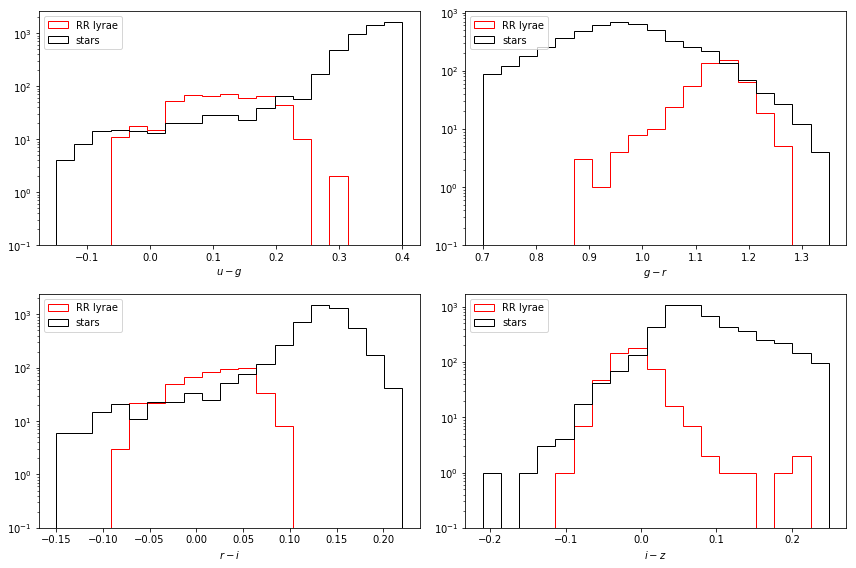

In [31]:
# Plotting the 1D color-distributions
plt.figure(figsize=(12, 8))

for i in range(4):
    color = X[:, i]
    bins = np.linspace(np.nanmin(color), np.nanmax(color), 20) # this is to have a consistent no of bins in both histograms
    
    plt.subplot(221 + i)
    plt.hist(color[isRR], bins=bins, log=True, color="r", histtype="step", label="RR lyrae")
    plt.hist(color[noRR], bins=bins, log=True, color="k", histtype="step", label="stars")
    plt.xlabel(color_names[i])
    plt.legend(loc="upper left")
    
plt.tight_layout()
plt.show()

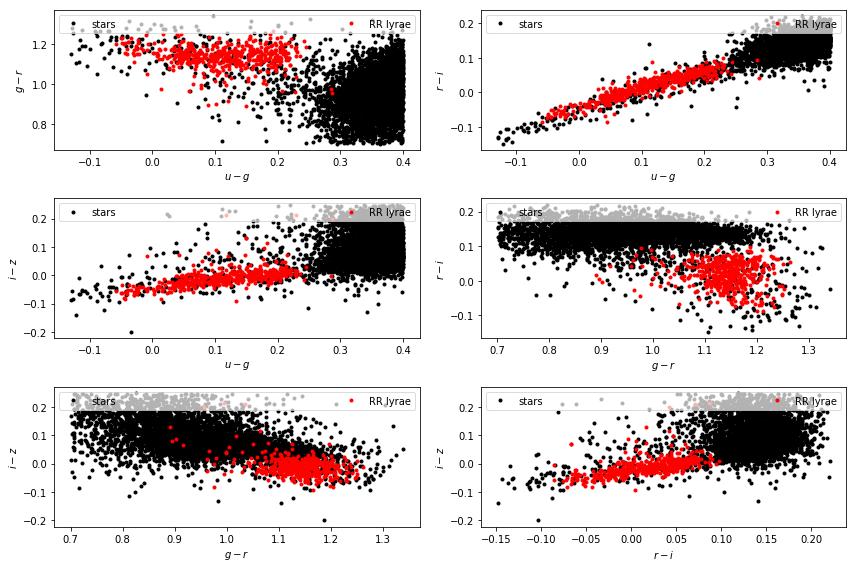

In [32]:
# Plotting 2D colors

# in scatter plots (not histograms), show 5000 non-RR Lyrae stars
N_plot = 5000 + int(sum(y))
noRR[:-N_plot] = False

plt.figure(figsize=(12, 8))

k = 1
for i in range(4):
    c1 = X[:, i]
    for j in range(i + 1, 4):
        c2 = X[:, j]
        plt.subplot(320 + k)
        plt.plot(c1[noRR], c2[noRR], "k.", label="stars")
        plt.plot(c1[isRR], c2[isRR], "r.", label="RR lyrae")
        plt.xlabel(color_names[i])
        plt.ylabel(color_names[j])
        plt.legend(loc="upper right", framealpha=0.7, mode="expand", ncol=2)
        k += 1
        
plt.tight_layout()
plt.show()

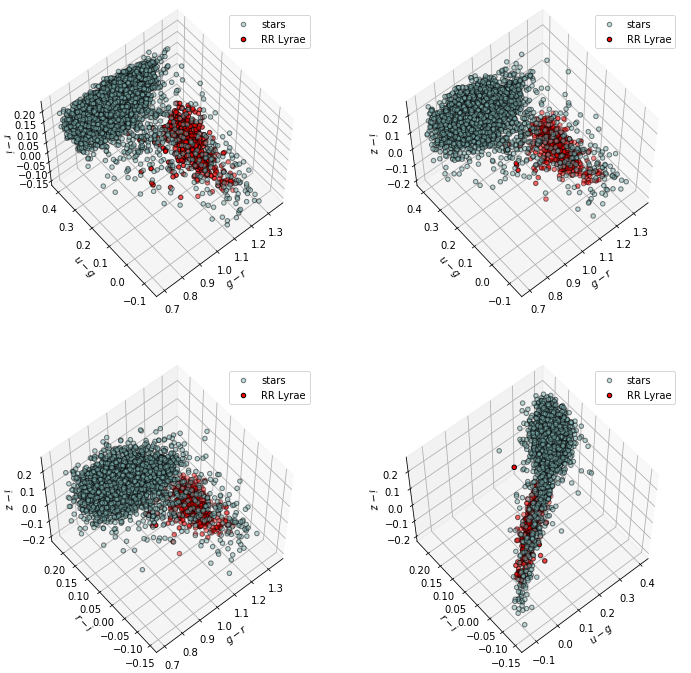

In [33]:
# Plotting 3D colors
from mpl_toolkits.mplot3d import Axes3D

combinations = [(1, 0, 2), (1, 0, 3), (1, 2, 3), (0, 2, 3)]

fig = plt.figure(figsize=(12, 12))
for index, combination in enumerate(combinations):
    i, j, k = combination
    ax = fig.add_subplot(221 + index, projection='3d')
    ax.view_init(60, -130)  # set camera position for better visualization
    ax.scatter(X[:, i][noRR], X[:, j][noRR], X[:, k][noRR], c=[0.5,0.7,0.7], marker="o", alpha=0.5, 
                                                                      edgecolors="k", label="stars")
    ax.scatter(X[:, i][isRR], X[:, j][isRR], X[:, k][isRR], c="r", edgecolors="k", label="RR Lyrae")
    ax.set_xlabel(color_names[i])
    ax.set_ylabel(color_names[j])
    ax.set_zlabel(color_names[k])
    ax.legend()

plt.show()

In [69]:
# RUNNING THE kNN CLASSIFIER

# split the sample in a training and test subset
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_st = np.sum(y == 0)   # number of non-RR Lyrae stars
N_rr = N_tot - N_st     # number of RR Lyrae
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_plot = 5000 + N_rr    # number of stars plotted (for better visualization)
Ncolors = np.arange(1, X.shape[1] + 1)    # number of available colors
print(np.sqrt(N_rr)) # because the best selection of k ~ sqrt(N)

21.9772609758


In [70]:
# PERFORM CLASSIFICATION FOR VARIOUS VALUES OF k

# for each 'k', store the classifier and predictions on test sample
classifiers = []
predictions = []
kvals = [1,10,20,50,100]                           # k values to be used

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)    # prepare the classifiers
        clf.fit(X_train[:, :nc], y_train)            # supply training data
        y_pred = clf.predict(X_test[:, :nc])         # predict class of test data
        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)
        
# use astroML
completeness, contamination = completeness_contamination(predictions, y_test)

print('Completeness and contamination per color (col) and per k (line)')
print('Colors: ',color_names)
print "completeness", completeness
print "contamination", contamination

Completeness and contamination per color (col) and per k (line)
('Colors: ', ['$u-g$', '$g-r$', '$r-i$', '$i-z$'])
completeness [[ 0.22627737  0.3649635   0.46715328  0.54014599]
 [ 0.00729927  0.23357664  0.40145985  0.53284672]
 [ 0.          0.24087591  0.4379562   0.55474453]
 [ 0.          0.24087591  0.38686131  0.51824818]
 [ 0.          0.24087591  0.35766423  0.47445255]]
contamination [[ 0.78014184  0.53271028  0.44347826  0.41732283]
 [ 0.875       0.44827586  0.24657534  0.23958333]
 [ 0.          0.4         0.25        0.23232323]
 [ 0.          0.3125      0.28378378  0.21978022]
 [ 0.          0.35294118  0.234375    0.24418605]]


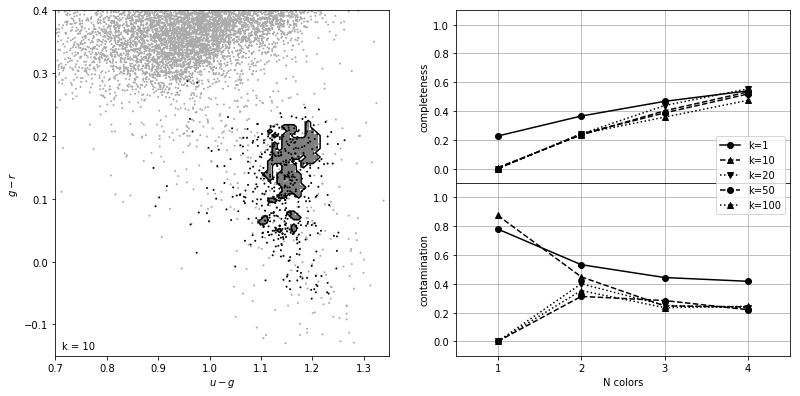

In [74]:
# COMPUTE DECISION BOUNDARY
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)


# PLOT THE RESULTS
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)
im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
im.set_clim(0, 2)
ax.contour(xx, yy, Z, [0.5], colors='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')
ax.text(0.02, 0.02, "k = %i" % kvals[1], transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.plot(Ncolors, completeness[2], 'v:k', ms=6, label='k=%i' % kvals[2])
ax.plot(Ncolors, completeness[3], 'o--k', ms=6, label='k=%i' % kvals[3])
ax.plot(Ncolors, completeness[4], '^:k', ms=6, label='k=%i' % kvals[4])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', label='k=%i' % kvals[1])
ax.plot(Ncolors, contamination[2], 'v:k', label='k=%i' % kvals[2])
ax.plot(Ncolors, contamination[3], 'o--k', label='k=%i' % kvals[3])
ax.plot(Ncolors, contamination[4], '^:k', label='k=%i' % kvals[4])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

# 2) Support Vector Machines

It separates the area of two or more classes with a hyperplane (if its 1D a linear) boundary which is chosen such that it leaves the maximum distance from all the classes. It then assigns the classification depending on where the object is located.

Performing SVM classification...
    Computing for 1 color(s)...
    Computing for 2 color(s)...
    Computing for 3 color(s)...
    Computing for 4 color(s)...
completeness [ 0.99270073  1.          1.          1.        ]
contamination [ 0.90014684  0.85347594  0.85347594  0.85471898]


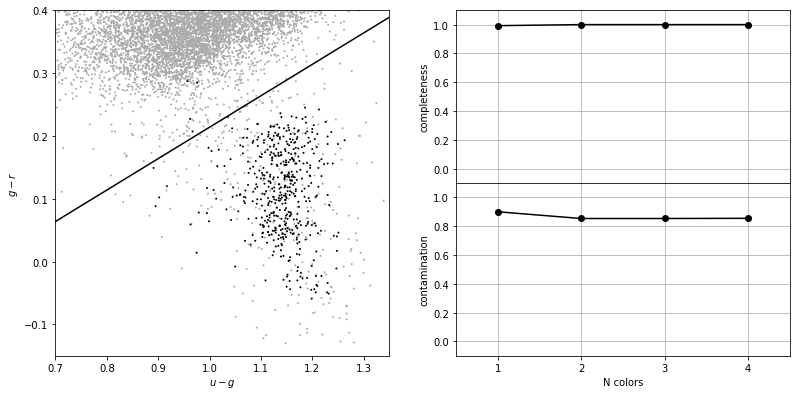

In [75]:
def apply_SVM(linear):
    if linear:
        kernel_to_use = "linear" # if 1D use linear boundary
        gamma_to_use = "auto"
    else:
        kernel_to_use = "rbf" # if n-D use hyperplane boundary
        gamma_to_use = 20.0

    def compute_SVM(Ncolors):
        classifiers = []
        predictions = []

        for nc in Ncolors:
            print "    Computing for", nc, "color(s)..."
            # perform support vector classification
            clf = SVC(kernel=kernel_to_use, gamma=gamma_to_use, class_weight='balanced')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers.append(clf)
            predictions.append(y_pred)

        return classifiers, predictions

    print("Performing SVM classification...")

    classifiers, predictions = compute_SVM(Ncolors)

    completeness, contamination = completeness_contamination(predictions, y_test)

    print "completeness", completeness
    print "contamination", contamination

    # COMPUTE THE DECISION BOUNDARY

    clf = classifiers[1]

    if linear:
        w = clf.coef_[0]
        a = -w[0] / w[1]
        yy = np.linspace(-0.1, 0.4)
        xx = a * yy - clf.intercept_[0] / w[1]
    else:
        xlim = (0.7, 1.35)
        ylim = (-0.15, 0.4)
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        # smooth the boundary
        from scipy.ndimage import gaussian_filter
        Z = gaussian_filter(Z, 2)

    # PLOT THE RESULTS

    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

    # left plot: data and decision boundary
    ax = fig.add_subplot(121)
    im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
    if linear:
        ax.plot(xx, yy, '-k')
    else:
        ax.contour(xx, yy, Z, [0.5], colors='k')

    im.set_clim(-0.5, 1)
    ax.set_xlim(0.7, 1.35)
    ax.set_ylim(-0.15, 0.4)
    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')

    # plot completeness vs Ncolors
    ax = fig.add_subplot(222)
    ax.plot(Ncolors, completeness, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('completeness')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    # plot contamination vs Ncolors
    ax = fig.add_subplot(224)
    ax.plot(Ncolors, contamination, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    ax.set_xlabel('N colors')
    ax.set_ylabel('contamination')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    plt.show()
    
apply_SVM(linear=True)

However if the boundary is not 1D-linear but 2D multinomial then:

Performing SVM classification...
    Computing for 1 color(s)...
    Computing for 2 color(s)...
    Computing for 3 color(s)...
    Computing for 4 color(s)...
completeness [ 1.  1.  1.  1.]
contamination [ 0.90108303  0.83901293  0.83573141  0.81561238]


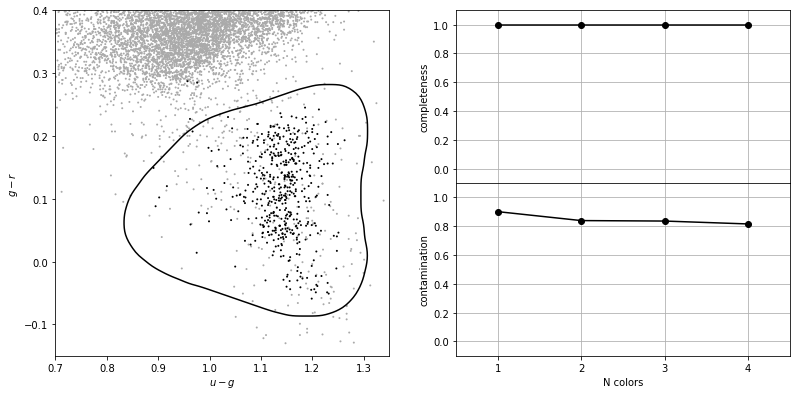

In [77]:
apply_SVM(linear=False)